# Dead Reckoning

<img src="Object1.png" width="400" height="400">
In this exercise, we will simulate the path of the two-dimensional object which can roll along the $x$ axis. The goal is to show that path obtained from the recorded information from sensors might differ from the actual path. Let's assume that we will move the drone (two-dimensional object) manually in a loop-shaped path in a manner that the top side of the drone always faces in the direction of the motion.
 

The sensors are providing the information regarding angular velocity $\tilde{\omega}$ and accelerations relative to the body frame $\tilde{a} =(\tilde{a}_y^b$, $\tilde{a}_z^b)$. We know that the measurements experience error from the sensor architecture and measured values can be expressed in the next form:

$$
\begin{align}
\tilde{\omega} &= \omega + b + \eta_{\omega}, \quad & \eta_{\omega} \sim N(0,\sigma^2_{\omega})\\
\tilde{a} & = a^{(g)}+a^{(l)} + \eta_{a}, \quad & \eta_{a} \sim N(0,\sigma^2_{a})
\end{align}
$$

Where $b$ is bias in measuring the angular velocity and $\eta_{\omega}, $ is a normal distribution of the measurement error. Similarly, the $\eta_a$ is the measurement error of the acceleration value which has the Gaussian profile. Additionally, the accelerometer measures the reactive force which compensates the gravity thus it is directed vertically up. **Note: The accelerometer at rest measures the gravity force in the opposite direction.**


In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from test_two_d_object import TestCode


pylab.rcParams['figure.figsize'] = 10, 10

We can define the object's state at any time using the state vector $X=(y,z,\phi,\dot{y},\dot{z})$. Similarly to the previous exercises, we also will include the `advance_state` function which will update the state vector for the next time step $t+dt$. The only difference is that we will break it into two separate parts one that updates the perceived attitude $\phi$ by `dead_reckoning_orientation` and the second one which will update the perceived linear motion by `dead_reckoning_position`.

We know that the measuring unit measures the acceleration consisting of the translational motion and the acceleration opposite to the gravity. Thus in order to get the actual acceleration in the inertial frame of reference, we need to convert the measured acceleration back to the linear acceleration $a^{(l)} = \tilde{a} - a^{(g)}$. This is achieved by knowing the roll angle and subtracting the gravity-related measurement from the acceleration measurements along the $z$ axis. 

Orientation will be updated by simply adding the measured angular velocity to the estimated roll angle $\phi(t+dt) =\phi(t)+\omega dt$.

`advance_state` combines the position and orientation updates. The position being updated before the orientation.


In [2]:
class ObjectInTwoD:
    
    def __init__(self):
        '''
        Initialize the ObjectInTwoD with zero state vector and declare the gravity constant
        '''
        self.X = np.zeros((5, 1))
        self.g = 9.81 * np.array([[0], [-1]])  # The opposite of the gravity thus directed opposite of the z-axis. 

        
    def rotation_matrix(self, phi):
        '''
        Calculates the two-dimensional rotation matrix for roll value
        '''
        r = np.array([[cos(phi), -sin(phi)], [sin(phi), cos(phi)]])
        
        return r

    
    def linear_acceleration(self, measured_acceleration, measured_phi):
        '''
        Returns the linear acceleration value in the inertial frame
        '''
        #TODO : Assign the proper values to the given variables 
        # The linear acceleration term in the body frame 
        a_body_frame = measured_acceleration - np.matmul(self.rotation_matrix(measured_phi), self.g)
        # Converting the linear acceleration in the body frame on the inertial frame. 
        a_inertial_frame = np.matmul(self.rotation_matrix(-measured_phi), a_body_frame)
        
        return a_inertial_frame
    
    def dead_reckoning_orientation(self, omega):
        '''
        Advances the roll angle (the third element of the state vector) by dt for omega value.
        '''
        #TODO: Update the state vector component of the roll angle 
        self.X[2] = self.X[2] + omega * dt         # integrating the roll angle 
        
    def dead_reckoning_position(self, measured_acceleration):
        '''
        Advance the position and velocity components of the state vector by dt for the measured acceleration. 
        '''

        perceived_phi = self.X[2]
        # TODO: Calculate the linear acceleration in the inertial frame 
        a = self.linear_acceleration(measured_acceleration, perceived_phi) 

        # TODO: 
        # Use the velocity components of the state vector to update the position components of the state vector
        # Use the linear acceleration in the inertial frame to update the velocity components of the state vector
        self.X[0] = self.X[0] + self.X[3] * dt   # y coordianate y= y + \dot{y} * dt
        self.X[1] = self.X[1] + self.X[4] * dt   # z coordianate z= z + \dot{z} * dt
        self.X[3] = self.X[3] + a[0] * dt        # change in velocity along the y is a_y * dt 
        self.X[4] = self.X[4] + a[1] * dt        # change in velocity along the z is a_z * dt  
        
    def advance_state(self, measured_acceleration, omega, dt):
        '''
        The advance state is used as the separate function which will call the position update dead-reckoning 
        function and then orientation update dead-reckoning function.
        '''

        self.dead_reckoning_position(measured_acceleration)
        self.dead_reckoning_orientation(omega)

        return self.X 

`linear_acceleration` is correct if it converts the acceleration measured in the body frame back to the inertial frame.

In [3]:
TestTwoDObject = ObjectInTwoD()
measured_phi = 0.6
y_dot_dot_body = 1.2
z_dot_dot_body = 0.5
measured_acceleration = np.array([[y_dot_dot_body], [z_dot_dot_body]])
TestCode.test_the_linear_acceleration(TestTwoDObject.linear_acceleration(measured_acceleration, measured_phi),
                                      measured_phi, measured_acceleration)

Test passed



In this section, we will generate the actual path of the object in two dimensions $y=y(t)$, $z=z(t)$ and $\phi=\phi(t)$. Based on the given path we can calculate the actual acceleration and angular velocity of the object in time $\ddot{y}(t)$, $\ddot{z}(t)$ and $\dot{\phi}(t)$. 

The path is generated with `flight_path`.


In [4]:
from flightpath import flight_path
t, dt, z_path, z_dot_path, z_dot_dot_path, y_path, y_dot_path, y_dot_dot_path, phi_path, phi_dot_path = flight_path()

Ploting the flight path. 

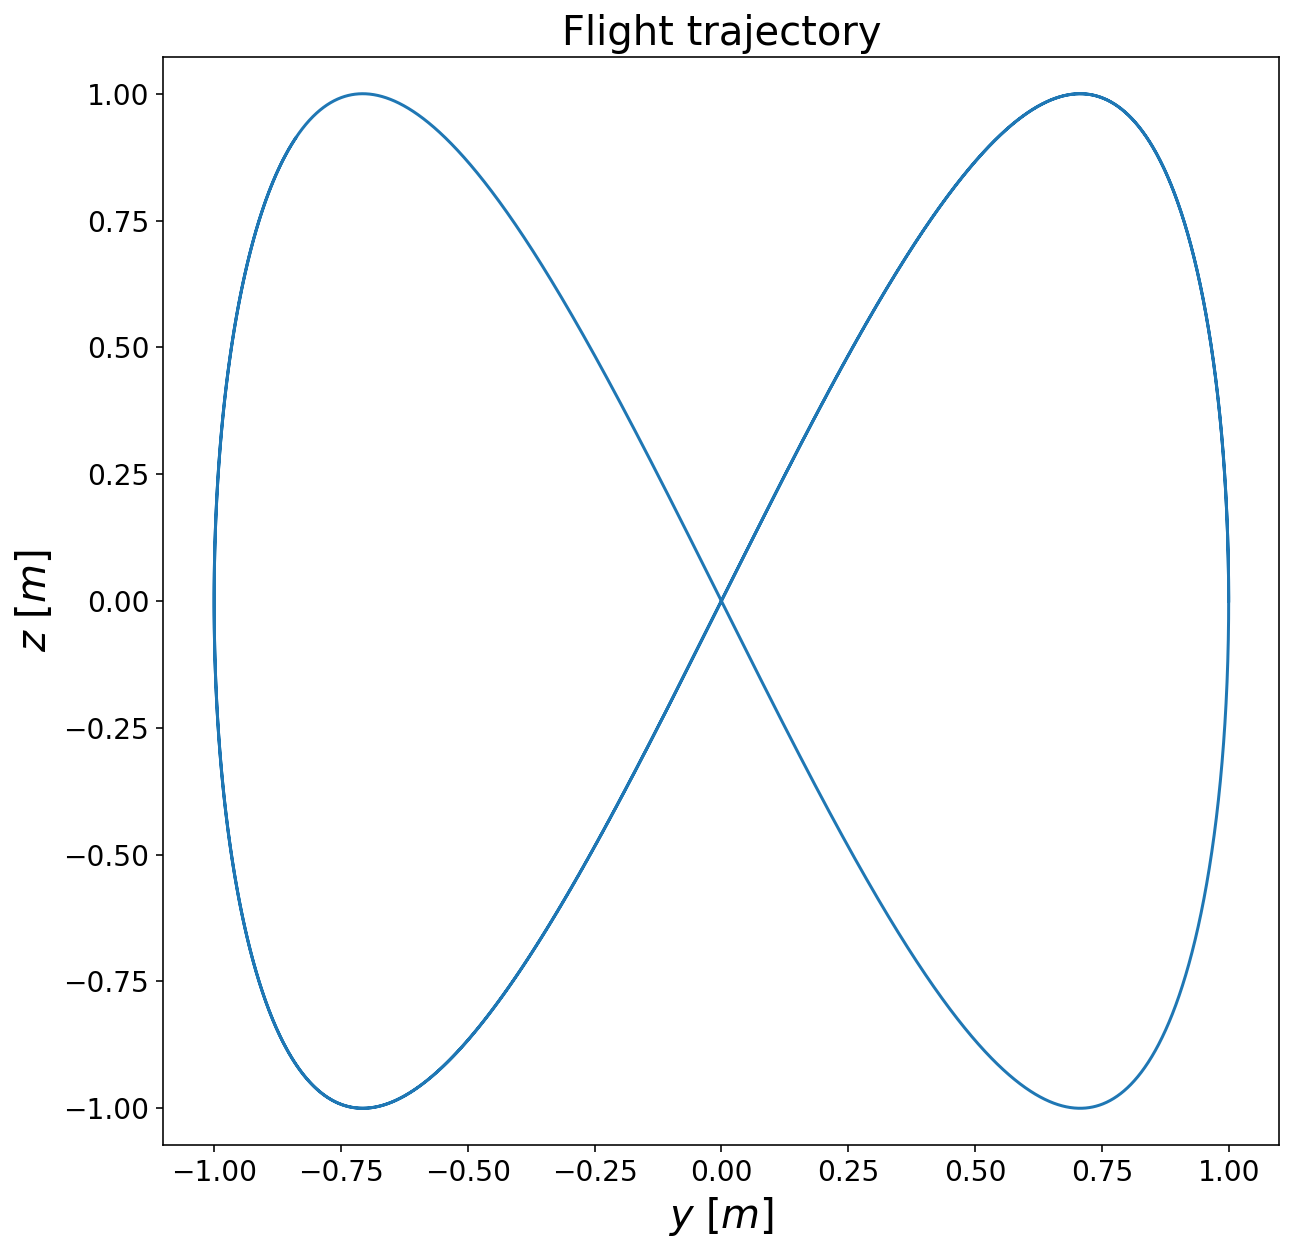

In [5]:
plt.plot(y_path, z_path)
plt.axis('equal')
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

# IMU Unit

In this section, we will create the IMU object which will have the next parameters $\sigma_a$ and $\sigma_{\omega}$, which are associated with the measurements and describe the Gaussian distribution of the measurement error. In this exercise, we will assume that **we do not have the bias errors.** 

The given object will be used to simulate the inertial measurement unit. We will transfer the actual acceleration and angular velocity and will add the measurement errors. 

Simulate angular velocity measurement of the sensor assuming that the bias of the measurement of the angular velocity is zero $b=0$. Thus for measured angular velocity:

$$
\tilde{\omega} = \omega + \eta_{\omega}, \quad  \eta_{\omega} \sim N(0,\sigma^2_{\omega})\\
$$

Similarly, we will simulate the measurements of the acceleration module. The measured acceleration has the next form:

$$
\tilde{a} = a^{(g)}+a^{(l)} + \eta_{a}, \quad \eta_{a} \sim N(0,\sigma^2_{a})
$$

where $a^{(g)}$ is the reactive force measured countaracting the gravity force, $a^{(l)}$ the acceleration in the inertial frame that drone experiense $(\ddot{y},\ddot{z})$ and finally $\eta_a$ is a measurement error which has a Gaussian form. The function will receive the value of the actual acceleration which is a two-element numpy array and the actual roll angle of the object.

Since the acceleration is measured in the body frame the linear acceleration is converted to body frame. Additionally, gravity and the measurement error elements are added.

In [6]:
class IMU:
    
    def __init__(self,
                 sigma_a = 0.0001,          # An error of acceleration measurement
                 sigma_omega = 0.00001      # An error of angular velocity measurement
                ):
        '''
        Initialize the IMU object using the sigma values for acceleration measurements 
        and the angular velocity measurement.  
        '''
        
        self.sigma_a  = sigma_a
        self.sigma_omega = sigma_omega
        self.g = 9.81 * np.array([[0], [-1]]) # The opposite of the gravity thus directed opposite of the z-axis. 
        
        
    def rotation_matrix(self, phi):
        '''
        Calculates the two-dimensional rotation matrix for roll value
        '''
        
        r = np.array([[cos(phi), -sin(phi)],
                      [sin(phi), cos(phi)]])
        return r
    

    def gyroscope_measurement(self, omega):
        '''
        Simulates the gyroscope measurement for the given true value of the angular velocity
        '''
        # TODO: Return the modeled measured value of the angular velocity.
        return omega + np.random.normal(0.0, self.sigma_omega)



    def accelerometer_measurement(self, acctual_a, phi):
        '''
        Simulates the measurement of the accelerometer in the body frame for the actual linear acceleration
        and the true roll angle phi.
        '''

        # TODO: Assign the proper values to the given variables 
        # Linear acceleration component in the body frame 
        linear_acc_bodyframe = np.matmul(self.rotation_matrix(phi), acctual_a)
        # gravity acceleration component in the body frame (directed up in the inertial frame)
        gravity_component = np.matmul(self.rotation_matrix(phi),self.g)
        # Error component of the acceleration 
        error_component = np.random.normal(0.0, self.sigma_a,(2, 1))

        measured_acceleration = linear_acc_bodyframe + gravity_component + error_component

        return measured_acceleration

Now we can test the `accelerometer_measurement` function if it can generate the measurement of the acceleratin in the body freame knowing the linear acceleration in the inertial frame we will initialize the IMU object with zero mean Gaussian for the acceleration measurements. 

In [7]:
TestIMUObject = IMU(sigma_a = 0.0)
actual_phi = 0.6
y_dot_dot = 1.2
z_dot_dot = 0.5
actual_acceleration = np.array([[y_dot_dot], [z_dot_dot]])

TestCode.test_the_IMU_acceleration_measurement(TestIMUObject.accelerometer_measurement(actual_acceleration, 
                                                                                       actual_phi),
                                               actual_acceleration, actual_phi)

Test passed


Now we will run the IMU and compare the actual path with the one generated by the IMU. 

In [8]:
# Declaration of the moving object
Obj = ObjectInTwoD()

# Declaration of the IMU object
IMU_unit = IMU()

# Initial state 
Obj.X = np.array([y_path[0], z_path[0], phi_path[0], y_dot_path[0], z_dot_path[0]])

# Creating the historical data of the objects state space 
object_state_history = Obj.X

for i in range(t.shape[0]):
    actual_omega = phi_dot_path[i]
    actual_a = np.array([[y_dot_dot_path[i]], [z_dot_dot_path[i]]])
    actual_phi = phi_path[i]
    
    measured_omega = IMU_unit.gyroscope_measurement(actual_omega)
    measured_a = IMU_unit.accelerometer_measurement(actual_a, actual_phi)
    
    object_state = Obj.advance_state(measured_a, measured_omega, dt)
    object_state_history = np.vstack((object_state_history, object_state))
    

Plotting the results. 

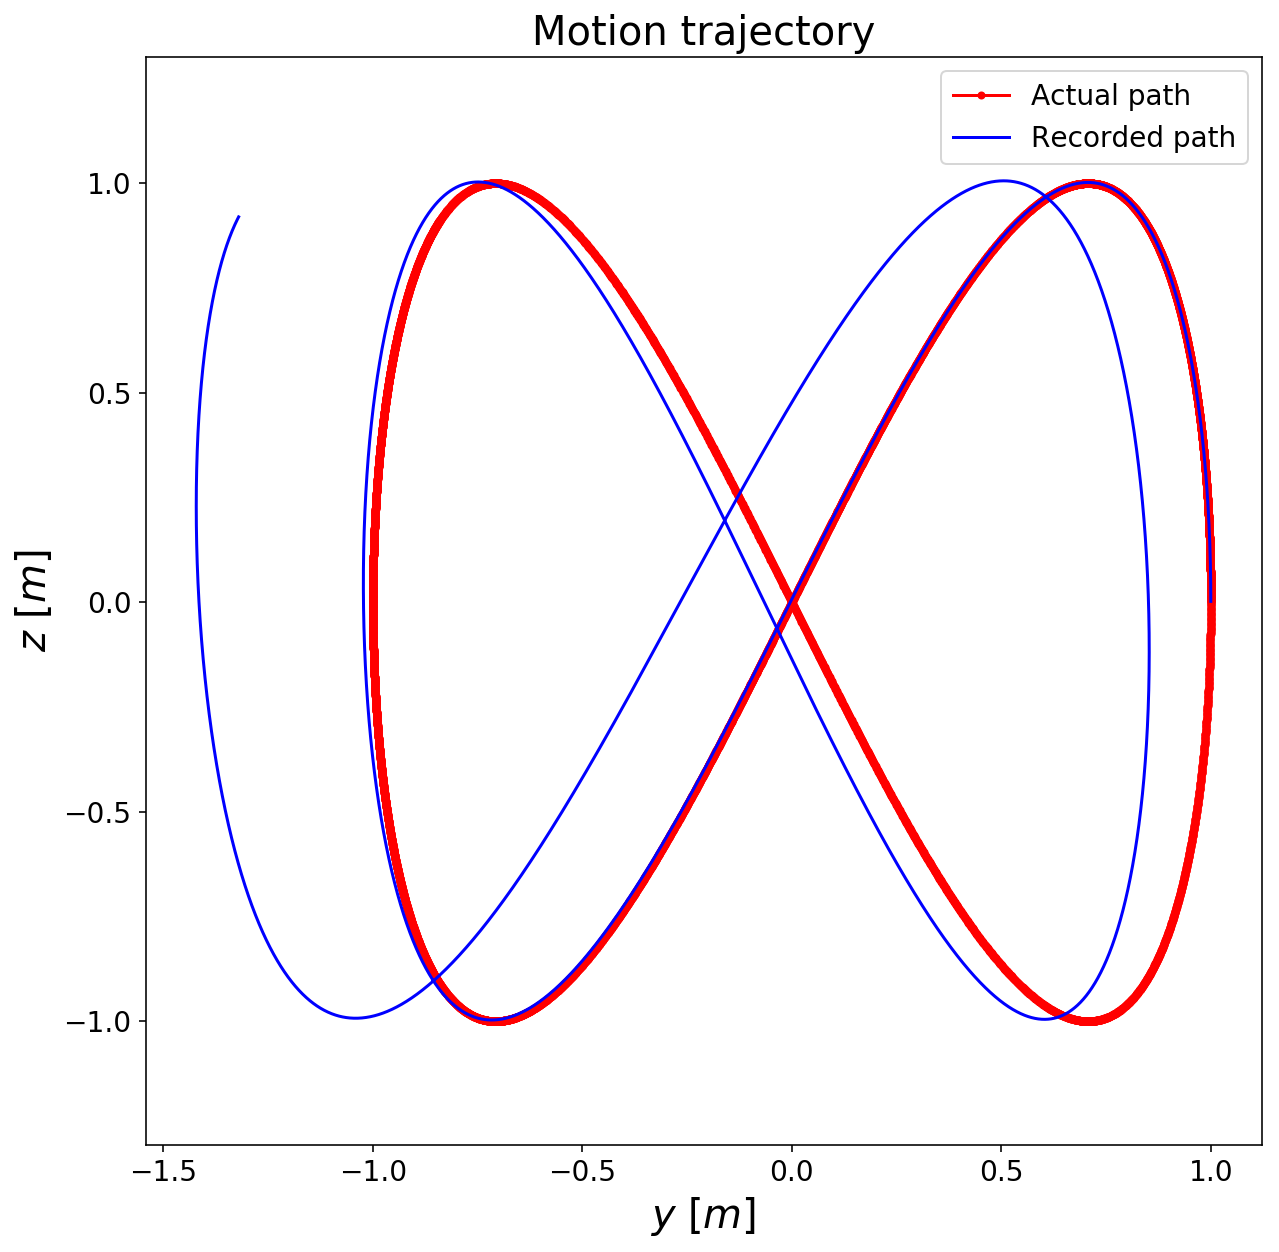

In [9]:
plt.plot( y_path, z_path,linestyle='-',marker='.',color='red')
plt.plot(object_state_history[:,0],object_state_history[:,1],linestyle='-',color='blue')
plt.title('Motion trajectory').set_fontsize(20)
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Actual path','Recorded path'],fontsize = 14)
plt.axis('equal')
plt.show()
